<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Constants" data-toc-modified-id="Imports-and-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Constants</a></span></li><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Helper Functions</a></span></li><li><span><a href="#Load-DHS-Data" data-toc-modified-id="Load-DHS-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load DHS Data</a></span></li><li><span><a href="#Load-LSMS-Data" data-toc-modified-id="Load-LSMS-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load LSMS Data</a></span><ul class="toc-item"><li><span><a href="#Neal-OOC-setup" data-toc-modified-id="Neal-OOC-setup-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Neal OOC setup</a></span></li></ul></li><li><span><a href="#Neal-NL-and-Labels-vs.-new-NL-and-Labels" data-toc-modified-id="Neal-NL-and-Labels-vs.-new-NL-and-Labels-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Neal NL and Labels vs. new NL and Labels</a></span></li><li><span><a href="#KNN" data-toc-modified-id="KNN-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>KNN</a></span><ul class="toc-item"><li><span><a href="#Neal-OOC-setup" data-toc-modified-id="Neal-OOC-setup-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Neal OOC setup</a></span></li><li><span><a href="#Label-vs.-NL" data-toc-modified-id="Label-vs.-NL-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Label vs. NL</a></span></li><li><span><a href="#Neal-Label-vs.-Neal-NL" data-toc-modified-id="Neal-Label-vs.-Neal-NL-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Neal Label vs. Neal NL</a></span></li><li><span><a href="#Neal-Label-vs.-NL" data-toc-modified-id="Neal-Label-vs.-NL-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Neal Label vs. NL</a></span></li></ul></li></ul></div>

# Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from collections import defaultdict
import os
import pickle
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.neighbors

from batchers import batcher, dataset_constants
from models.histograms import (
    get_per_image_histograms,
    plot_band_hists,
    plot_label_hist,
    split_nl_hist)
from models.linear_model import ridge_cv
from utils.analysis import calc_score, evaluate
from utils.general import load_npz
from utils.plot import scatter_preds

In [3]:
FOLDS = ['A', 'B', 'C', 'D']
SPLITS = ['train', 'val', 'test']

MEANS = dataset_constants.MEANS_DICT['2009-17']
STD_DEVS = dataset_constants.STD_DEVS_DICT['2009-17']

# Helper Functions

In [4]:
def background_gradient(df, cmap, m=None, M=None):
    '''
    Args
    - df: pd.DataFrame
    - cmap: str, name of matplotlib colormap
    - m: float, value corresponding to lowest color in cmap
    - M: float, value corresponding to highest color in cmap

    Returns
    - styles_df: pd.DataFrame
    '''
    if m is None:
        m = np.nanmin(df.values)
    if M is None:
        M = np.nanmax(df.values)
    normed = np.clip((df.values - m) / (M - m), 0, 1)
    normed[np.isnan(normed)] = 0
    cmap = plt.cm.get_cmap(cmap)
    styles = []
    for rgba in cmap(normed.ravel()):
        c = matplotlib.colors.rgb2hex(rgba)
        if np.mean(rgba) < 0.75:
            styles.append(f'background-color: {c}; color: white;')
        else:
            styles.append(f'background-color: {c};')
    styles = np.asarray(styles).reshape(df.shape)
    styles_df = pd.DataFrame(styles, index=df.index, columns=df.columns)
    styles_df[df.isna()] = f'background-color: white'
    return styles_df

In [5]:
def neal_ooc(df, country_order):
    '''
    Args
    - df: pd.DataFrame
    - countries: list of countries
    '''
    knn = sklearn.neighbors.KNeighborsRegressor(100)
    neal_ooc_df = pd.DataFrame(columns=['train_on', 'eval_on', 'r2'], dtype=np.float32)
    neal_ooc_df.set_index(['train_on', 'eval_on'], inplace=True)
    for train_c in country_order:
        for test_c in country_order:
            if test_c == train_c: continue

            train_mask = (df['country'] == train_c)
            test_mask = (df['country'] == test_c)
            knn.fit(X=df.loc[train_mask, ['neal_nl']].values, y=df.loc[train_mask, 'neal_label'].values)
            preds = knn.predict(X=df.loc[test_mask, ['neal_nl']].values)
            neal_ooc_df.loc[(train_c, test_c), :] = calc_score(
                df.loc[test_mask, 'neal_label'].values, preds, metric='r2')

    rows = country_order
    cols = rows[::-1]

    return neal_ooc_df.stack().reset_index(level=2, drop=True).unstack('train_on').loc[rows, cols]

# Load DHS Data

In [4]:
NEAL_DIR = '/atlas/u/nj/dhs/'

In [5]:
surveys = [
    'malawi_dhs_2010',
    'nigeria_dhs_2013',
    'rwanda_dhs_2010',
    'tanzania_dhs_2010',
    'uganda_dhs_2011',
]

COUNTRIES = ['malawi', 'nigeria', 'rwanda', 'tanzania', 'uganda']
DMSP_COUNTRIES = ['malawi', 'rwanda', 'tanzania', 'uganda']

In [6]:
df = pd.DataFrame(columns=['lat', 'lon', 'country', 'year', 'neal_nl', 'neal_label', 'nl', 'label'])

In [7]:
file_path = 'data/dhs_image_hists.npz'
result = load_npz(file_path)
image_hists = result['image_hists']
labels = result['labels']
locs = result['locs']
years = result['years']
nls_center = result['nls_center']
nls_mean = result['nls_mean']

dmsp_mask = years < 2012
viirs_mask = ~dmsp_mask

image_hists: dtype=int64, shape=(19669, 8, 102)
labels: dtype=float32, shape=(19669,)
locs: dtype=float32, shape=(19669, 2)
years: dtype=int32, shape=(19669,)
nls_center: dtype=float32, shape=(19669,)
nls_mean: dtype=float32, shape=(19669,)


In [8]:
loc_to_index = {
    (lat, lon): i
    for i, (lat, lon) in enumerate(locs)
}
assert len(loc_to_index) == len(locs)

In [9]:
for survey in surveys:
    country, year = survey.split('_dhs_')
    year = int(year)

    folder = os.path.join(NEAL_DIR, survey, 'data')
    image_counts = np.load(os.path.join(folder, 'cluster_image_counts.npy'))
    mask = (image_counts >= 10)

    clocs = np.load(os.path.join(folder, 'cluster_locs.npy'))
    clocs = clocs[mask]

    neal_nls = np.load(os.path.join(folder, 'cluster_nightlights.npy'))
    neal_nls = neal_nls[mask]

    neal_labels = np.load(os.path.join(folder, 'cluster_assets.npy'))
    neal_labels = neal_labels[mask]

    indices = [
        loc_to_index[(lat, lon)]
        for lat, lon in clocs.astype(np.float32)
    ]
    
    cdf = pd.DataFrame(data={
        'lat': clocs[:, 0],
        'lon': clocs[:, 1],
        'country': country,
        'year': year,
        'neal_nl': neal_nls,
        'neal_label': neal_labels,
        'nl': nls_mean[indices],
        'label': labels[indices]
    })
    df = pd.concat([df, cdf])
df.reset_index(inplace=True, drop=True)

In [10]:
with pd.option_context('display.max_rows', 6):
    display(df)

,lat,lon,country,year,neal_nl,neal_label,nl,label
0,-14.293995,34.468751,malawi,2010,0.0,0.170203,-0.173862,-0.476676
1,-14.791538,35.033085,malawi,2010,0.0,-0.137892,-0.173862,-0.556283
2,-13.435848,32.945216,malawi,2010,0.0,-0.265330,-0.173862,-0.559472
...,...,...,...,...,...,...,...,...
3031,-0.796772,29.931162,uganda,2011,5.2,1.256519,-0.103255,0.685674
3032,-0.967814,29.988417,uganda,2011,0.0,-0.419588,-0.173862,-0.651027
3033,-0.688925,29.938125,uganda,2011,0.0,-0.209665,-0.173862,-0.565248


# Load LSMS Data

In [6]:
NEAL_LSMS_DIR = '/atlas/u/nj/lsms'

In [7]:
lsms_surveys = [
    'malawi_lsms_2013',
    'nigeria_lsms_2012_2013',
    'tanzania_lsms_2012_2013',
    'uganda_lsms_2011_2012',
]

In [8]:
def load_neal_lsms_data(lsms_surveys):
    df = pd.DataFrame(columns=['lat', 'lon', 'country', 'year', 'neal_nl', 'neal_label'])
    for survey in lsms_surveys:
        country, years = survey.split('_lsms_')
        year = int(years.split('_')[0])

        folder = os.path.join(NEAL_LSMS_DIR, survey, 'data')
        image_counts = np.load(os.path.join(folder, 'cluster_image_counts.npy'))
        mask = (image_counts >= 10)

        households = np.load(os.path.join(folder, 'cluster_households.npy'))
        mask &= (households >= 2)

        clocs = np.load(os.path.join(folder, 'cluster_locs.npy'))
        clocs = clocs[mask]

        neal_nls = np.load(os.path.join(folder, 'cluster_nightlights.npy'))
        neal_nls = neal_nls[mask]

        neal_labels = np.load(os.path.join(folder, 'cluster_consumptions.npy'))
        neal_labels = neal_labels[mask]

        cdf = pd.DataFrame(data={
            'lat': clocs[:, 0],
            'lon': clocs[:, 1],
            'country': country,
            'year': year,
            'neal_nl': neal_nls,
            'neal_label': neal_labels,
        })
        df = pd.concat([df, cdf])
    df.reset_index(inplace=True, drop=True)
    return df

lsms_df = load_neal_lsms_data(lsms_surveys)
with pd.option_context('display.max_rows', 6):
    display(lsms_df)

,lat,lon,country,year,neal_nl,neal_label
0,-9.504460,33.230200,malawi,2013,0.0,1.460405
1,-9.667920,33.393700,malawi,2013,0.0,1.946366
2,-9.809980,33.387300,malawi,2013,0.0,1.517353
...,...,...,...,...,...,...
1408,-0.925602,30.794159,uganda,2011,0.0,2.502750
1409,-0.757246,30.807199,uganda,2011,0.0,5.869549
1410,-0.151138,30.948854,uganda,2011,0.0,2.363786


## Neal OOC setup

In [9]:
lsms_country_row_order = ['malawi', 'uganda', 'tanzania', 'nigeria']
neal_ooc_lsms_df = neal_ooc(df=lsms_df, country_order=lsms_country_row_order)
display(neal_ooc_lsms_df.style.apply(
    background_gradient, cmap='coolwarm',
    m=0.18, M=0.57,
    axis=None).format('{:.2f}'))

train_on,nigeria,tanzania,uganda,malawi
eval_on,,,,
malawi,0.28,0.30,0.29,nan
uganda,0.42,0.40,nan,0.38
tanzania,0.56,nan,0.55,0.54
nigeria,nan,0.30,0.31,0.28


In [10]:
neal_original_lsms_df = pd.DataFrame(data=[
    [.25, .34, .37, .42],
    [.34, .38, .46, .37],
    [.44, .56, .47, .48],
    [.41, .30, .26, .19]
], index=lsms_country_row_order, columns=lsms_country_row_order[::-1])
neal_original_lsms_df.index.name = 'eval_on'
neal_original_lsms_df.columns.name = 'train_on'
display(neal_original_lsms_df.style.apply(
    background_gradient,
    m=0.18, M=0.57,
    cmap='coolwarm', axis=None))

train_on,nigeria,tanzania,uganda,malawi
eval_on,,,,
malawi,0.25,0.34,0.37,0.42
uganda,0.34,0.38,0.46,0.37
tanzania,0.44,0.56,0.47,0.48
nigeria,0.41,0.3,0.26,0.19


In [11]:
concat_df = pd.concat(
    [neal_ooc_lsms_df, neal_original_lsms_df],
    keys=['KNN on scalar NL', 'Science paper'])
display(concat_df.style.apply(
    background_gradient, cmap='coolwarm',
    m=0.18, M=0.57,
    axis=None).format('{:.2f}'))

# Neal NL and Labels vs. new NL and Labels

In [12]:
import seaborn as sns

Neal Label vs. Label: r^2 = 0.5900936204254654


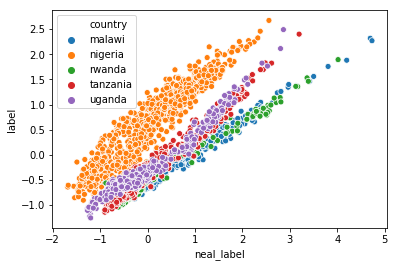

In [15]:
sns.scatterplot(data=df, x='neal_label', y='label', hue='country')
r2 = calc_score(df['neal_label'], df['label'], metric='r2')
print('Neal Label vs. Label: r^2 =', r2)

Neal NL vs. NL: r^2 = 0.7804754226120915
*Note: NL for Nigeria (2013) is VIIRS, while all others are DMSP


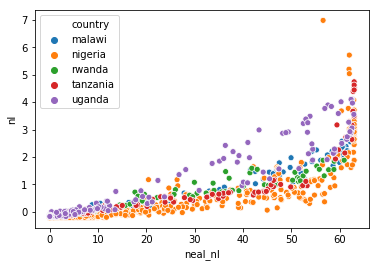

In [18]:
sns.scatterplot(data=df, x='neal_nl', y='nl', hue='country')
r2 = calc_score(df['neal_nl'], df['nl'], metric='r2')
print('Neal NL vs. NL: r^2 =', r2)
print('*Note: NL for Nigeria (2013) is VIIRS, while all others are DMSP')

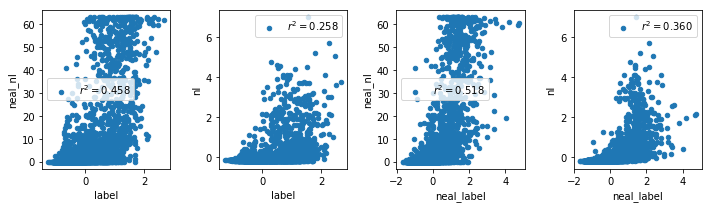

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
i = 0
for label_col in ['label', 'neal_label']:
    for nl_col in ['neal_nl', 'nl']:
        r2 = calc_score(df[label_col], df[nl_col], metric='r2')
        df.plot.scatter(x=label_col, y=nl_col, ax=axs[i], label=f'$r^2 = {r2:.3f}$')
        axs[i].legend()
        i += 1
fig.tight_layout()

# KNN

In [14]:
def knn_nl(labels, years, nls_center, train_idxs, test_idxs, k=5):
    '''
    Args
    - labels: np.array, shape [N]
    - years: np.array, shape [N]
    - nls_center: np.array, shape [N]
    - splits: dict, split (str) => np.array
    - k: int, k for KNN
    '''
    train_nls = nls_center[train_idxs]

    # test
    test_nls = nls_center[test_idxs]
    test_labels = labels[test_idxs]
    preds = np.zeros_like(test_labels)

    knn_dmsp = sklearn.neighbors.KNeighborsRegressor(k)
    knn_viirs = sklearn.neighbors.KNeighborsRegressor(k)

    dmsp_mask = years < 2012
    viirs_mask = ~dmsp_mask

    for mask, model in [(dmsp_mask, knn_dmsp), (viirs_mask, knn_viirs)]:
        train_mask = mask[train_idxs]
        test_mask = mask[test_idxs]

        if np.sum(test_mask) == 0:
            continue

        # assign each unique NL value the same label
        u, indices = np.unique(train_nls[train_mask], return_inverse=True)
        mean_labels = np.zeros_like(u)
        for i, nl in enumerate(u):
            mean_labels[i] = np.mean(labels[nls_center == nl])

        model.fit(X=train_nls[train_mask].reshape(-1, 1), y=mean_labels[indices])
        preds[test_mask] = model.predict(X=test_nls[test_mask].reshape(-1, 1))

    return preds, knn_dmsp, knn_viirs

In [15]:
def knn_cv_wrapper(labels, years, nls, folds, keep=1.0, seed=None, savepath=None, verbose=False):
    '''
    Args
    - labels: np.array, shape [N]
    - years: np.array, shape [N]
    - nls: np.array, shape [N]
    - folds: dict, folds[f][split] is a np.array of indices
    - keep: float, fraction of training and validation data to use
    - seed: int, random seed
    - savepath: str, path to save predictions
    - verbose: bool, whether to print out validation performance on each fold

    Returns
    - best_models: tuple of sklearn.neighbors.KNeighborsRegressor
        best models from the last fold
    - test_preds: np.array, shape [N]
    - ks: np.array, shape [K]
    - r2s: np.array, shape [K]
    - R2s: np.array, shape [K]
    - savepath: str, path to save npz file
    '''
    N = len(labels)
    assert len(years) == N
    assert len(nls) == N
    if savepath is not None:
        assert not os.path.exists(savepath)

    test_preds = np.zeros_like(labels)
    ks = np.asarray([1, 2, 5, 10, 30, 50, 100, 200, 500, 1000])
    fold_keys = sorted(folds.keys())
    r2s = np.ones([len(fold_keys), len(ks)]) * (-np.inf)
    R2s = np.ones([len(fold_keys), len(ks)]) * (-np.inf)

    dmsp_mask = years < 2012
    viirs_mask = ~dmsp_mask

    for i, f in enumerate(fold_keys):
        if verbose:
            print(f'Runing fold {f}...')
        test_idxs = folds[f]['test']
        best_models = None

        for j, k in enumerate(ks):
            train_idxs = folds[f]['train']
            val_idxs = folds[f]['val']

            num_train = int(len(train_idxs) * keep)
            num_val = int(len(val_idxs) * keep)
            if num_train < k or num_val < k:
                print('num_train:', num_train, 'num_val:', num_train, 'k:', k)
                continue

            if keep < 1:
                if seed is not None:
                    np.random.seed(seed)
                train_idxs = np.random.choice(
                    train_idxs, size=num_train, replace=False)
                val_tfrecord_paths = np.random.choice(
                    val_idxs, size=num_val, replace=False)

            val_preds, knn_dmsp, knn_viirs = knn_nl(
                labels, years, nls, train_idxs=train_idxs,
                test_idxs=val_idxs, k=k)
            r2 = calc_score(labels=labels[val_idxs], preds=val_preds, metric='r2')
            R2 = calc_score(labels=labels[val_idxs], preds=val_preds, metric='R2')
            if R2 > np.max(R2s[i]):
                best_models = (knn_dmsp, knn_viirs)
            r2s[i, j], R2s[i, j] = r2, R2
            if verbose:
                print(f'fold={f}, k={k:4d}, val_r2={r2:0.4f}, val_R2={R2:0.4f}')

        for i, mask in enumerate([dmsp_mask, viirs_mask]):
            idxs = np.nonzero(mask)[0]
            if len(idxs) <= 0:
                continue
            test_preds[idxs] = best_models[i].predict(nls[idxs].reshape(-1, 1))

    evaluate(labels=labels, preds=test_preds, do_print=True, title='test preds')

    if savepath is not None:
        os.makedirs(os.path.dirname(savepath), exist_ok=True)
        np.savez_compressed(savepath, test_preds=test_preds, labels=labels)
        
    return best_models, test_preds, ks, r2s, R2s

def plot_knn_val_performance(nl_result, labels, title):
    '''
    Args
    - nl_result: tuple (models, ks, r2s, R2s), output of knn_cv_wrapper
    - labels: np.array
    - title: str
    '''
    _, test_preds, ks, r2s, R2s = nl_result
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 3))
    for i, f in enumerate(FOLDS):
        print(f'fold {f}, chosen k:', ks[np.argmax(R2s[i])])
        axs[0].plot(ks, r2s[i], label=f'fold={f}, $r^2$')
        axs[1].plot(ks, R2s[i], label=f'fold={f}, $R^2$')
    for ax in axs:
        ax.legend()
        ax.grid()
        ax.set(xlabel='k', xscale='log')
    axs[0].set(ylabel='score')
    fig.suptitle(f'{title} validation KNN performance vs. K', y=1.02)
    fig.tight_layout()
    plt.show()

def plot_knn_test(nls_center_result, nls_mean_result, labels,
                  nl0_center_mask, nl0_mean_mask, title):
    '''
    Args
    - *_result: tuple (models, ks, r2s, R2s), output of knn_cv_wrapper
    - labels: np.array, shape [N]
    - *_mask: np.array, shape [N]
    - title: str
    '''
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(6, 3))
    results = [nls_center_result, nls_mean_result]
    nl0_masks = [nl0_center_mask, nl0_mean_mask]
    for result, nl0_mask, ax in zip(results, nl0_masks, axs):
        _, test_preds, ks, r2s, R2s = result
        scatter_preds(labels, test_preds, ax=ax)
        ax.scatter(x=labels[nl0_mask], y=test_preds[nl0_mask], c='red', s=2, label='NL = 0')
        ax.legend()
    axs[0].set_title(f'KNN on NL Center ({title})')
    axs[1].set_title(f'KNN on NL Mean ({title})')
    fig.tight_layout()
    plt.show()

In [17]:
# 'A': {
#     'train': np.array([1, 10, 13, ...]),
#     ...
# }
ooc_folds = {
    f: {split: [] for split in SPLITS}
    for f in FOLDS
}

for i, f in enumerate(FOLDS):
    ooc_folds[f] = {}
    test_country = DMSP_COUNTRIES[i]
    val_country = DMSP_COUNTRIES[(i+1)%4]
    train_countries = set(DMSP_COUNTRIES) - {test_country, val_country}
    ooc_folds[f]['test'] = np.nonzero((df['country'] == test_country).values)[0]
    ooc_folds[f]['val'] = np.nonzero((df['country'] == val_country).values)[0]
    ooc_folds[f]['train'] = np.nonzero(df['country'].isin(train_countries).values)[0]

In [18]:
DMSP0 = -MEANS['DMSP'] / STD_DEVS['DMSP']
VIIRS0 = -MEANS['VIIRS'] / STD_DEVS['VIIRS']
nl0_center_mask = ((nls_center == DMSP0) & dmsp_mask) | ((nls_center == VIIRS0) & viirs_mask)
nl0_mean_mask = ((nls_mean == DMSP0) & dmsp_mask) | ((nls_mean == VIIRS0) & viirs_mask)

In [19]:
country_indices = {
    country: np.nonzero((df['country'] == country).values)[0]
    for country in COUNTRIES
}

## Neal OOC setup
Choose k=100

In [ ]:
for survey in surveys:
    country, year = survey.split('_dhs_')
    year = int(year)

    folder = os.path.join(NEAL_DIR, survey, 'data')
    image_counts = np.load(os.path.join(folder, 'cluster_image_counts.npy'))
    mask = (image_counts >= 10)

    clocs = np.load(os.path.join(folder, 'cluster_locs.npy'))
    clocs = clocs[mask]

    neal_nls = np.load(os.path.join(folder, 'cluster_nightlights.npy'))
    neal_nls = neal_nls[mask]

    neal_labels = np.load(os.path.join(folder, 'cluster_assets.npy'))
    neal_labels = neal_labels[mask]

    indices = [
        loc_to_index[(lat, lon)]
        for lat, lon in clocs.astype(np.float32)
    ]
    
    cdf = pd.DataFrame(data={
        'lat': clocs[:, 0],
        'lon': clocs[:, 1],
        'country': country,
        'year': year,
        'neal_nl': neal_nls,
        'neal_label': neal_labels,
        'nl': nls_mean[indices],
        'label': labels[indices]
    })
    df = pd.concat([df, cdf])
df.reset_index(inplace=True, drop=True)

In [283]:
dhs_country_row_order = ['rwanda', 'malawi', 'uganda', 'tanzania', 'nigeria']
neal_ooc_df = neal_ooc(df=df, country_order=dhs_country_row_order)
display(neal_ooc_df.style.apply(
    background_gradient, cmap='coolwarm',
    m=0.24, M=0.79,
    axis=None).format('{:.2f}'))

train_on,nigeria,tanzania,uganda,malawi,rwanda
eval_on,,,,,
rwanda,0.78,0.76,0.78,0.79,nan
malawi,0.62,0.60,0.61,nan,0.57
uganda,0.68,0.69,nan,0.67,0.58
tanzania,0.72,nan,0.64,0.70,0.57
nigeria,nan,0.66,0.60,0.65,0.54


In [285]:
neal_original_df = pd.DataFrame(data=[
    [.55, .68, .66, .59, .75],
    [.40, .42, .43, .55, .42],
    [.56, .61, .66, .55, .56],
    [.43, .58, .51, .40, .47],
    [.69, .50, .46, .24, .39],
], index=dhs_country_row_order, columns=dhs_country_row_order[::-1])
neal_original_df.index.name = 'eval_on'
neal_original_df.columns.name = 'train_on'
display(neal_original_df.style.apply(
    background_gradient,
    m=0.24, M=0.79,
    cmap='coolwarm', axis=None))

train_on,nigeria,tanzania,uganda,malawi,rwanda
eval_on,,,,,
rwanda,0.55,0.68,0.66,0.59,0.75
malawi,0.4,0.42,0.43,0.55,0.42
uganda,0.56,0.61,0.66,0.55,0.56
tanzania,0.43,0.58,0.51,0.4,0.47
nigeria,0.69,0.5,0.46,0.24,0.39


In [286]:
concat_df = pd.concat(
    [neal_ooc_df, neal_original_df],
    keys=['KNN on scalar NL', 'Science paper'])
display(concat_df.style.apply(
    background_gradient, cmap='coolwarm',
    m=0.24, M=0.79,
    axis=None).format('{:.2f}'))

## Label vs. NL

In [35]:
nls_mean_result = knn_cv_wrapper(
    labels=df['label'].values, years=df['year'].values, nls=df['nl'].values, folds=ooc_folds,
    savepath=None)
test_preds = nls_mean_result[1]
for country in COUNTRIES:
    indices = country_indices[country]
    evaluate(labels=df.loc[indices, 'label'], preds=test_preds[indices], do_print=True, title=country)

num_train: 848 num_val: 848 k: 500
num_train: 848 num_val: 848 k: 1000
num_train: 1220 num_val: 1220 k: 500
num_train: 1220 num_val: 1220 k: 1000
num_train: 1319 num_val: 1319 k: 500
num_train: 1319 num_val: 1319 k: 1000
num_train: 947 num_val: 947 k: 1000
test preds	- r^2: 0.641, R^2: 0.581, mse: 0.133, rank: 0.650
malawi	- r^2: 0.559, R^2: 0.547, mse: 0.104, rank: 0.590
rwanda	- r^2: 0.717, R^2: 0.664, mse: 0.083, rank: 0.555
tanzania	- r^2: 0.633, R^2: 0.512, mse: 0.206, rank: 0.759
uganda	- r^2: 0.723, R^2: 0.593, mse: 0.172, rank: 0.752


fold A, chosen k: 100
fold B, chosen k: 30
fold C, chosen k: 30
fold D, chosen k: 200


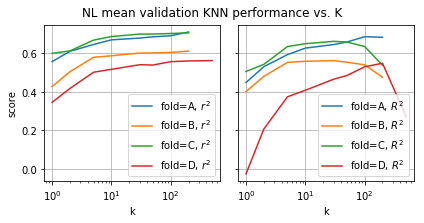

In [36]:
plot_knn_val_performance(nls_mean_result, df['label'].values, title='NL mean')

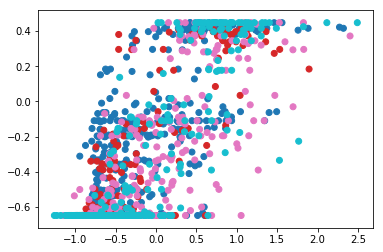

In [37]:
plt.scatter(df['label'], test_preds, c=df['country'].map(COUNTRIES.index), cmap='tab10')

## Neal Label vs. Neal NL

In [32]:
nls_mean_result = knn_cv_wrapper(
    labels=df['neal_label'].values, years=df['year'].values, nls=df['neal_nl'].values, folds=ooc_folds,
    savepath=None)
test_preds = nls_mean_result[1]
for country in COUNTRIES:
    indices = country_indices[country]
    evaluate(labels=df.loc[indices, 'neal_label'], preds=test_preds[indices], do_print=True, title=country)

num_train: 848 num_val: 848 k: 500
num_train: 848 num_val: 848 k: 1000
num_train: 1220 num_val: 1220 k: 500
num_train: 1220 num_val: 1220 k: 1000
num_train: 1319 num_val: 1319 k: 500
num_train: 1319 num_val: 1319 k: 1000
num_train: 947 num_val: 947 k: 1000
test preds	- r^2: 0.673, R^2: 0.671, mse: 0.232, rank: 0.636
malawi	- r^2: 0.616, R^2: 0.601, mse: 0.265, rank: 0.579
rwanda	- r^2: 0.793, R^2: 0.764, mse: 0.164, rank: 0.485
tanzania	- r^2: 0.701, R^2: 0.700, mse: 0.212, rank: 0.752
uganda	- r^2: 0.665, R^2: 0.656, mse: 0.270, rank: 0.712


fold A, chosen k: 30
fold B, chosen k: 100
fold C, chosen k: 200
fold D, chosen k: 100


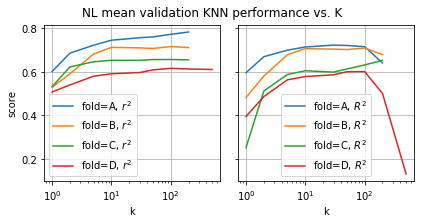

In [33]:
plot_knn_val_performance(nls_mean_result, labels, title='NL mean')

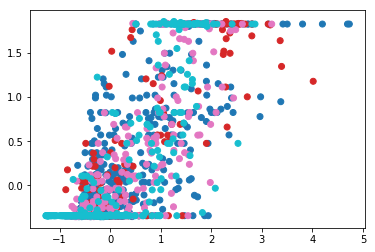

In [34]:
plt.scatter(df['neal_label'], test_preds, c=df['country'].map(COUNTRIES.index), cmap='tab10')

## Neal Label vs. NL

In [26]:
nls_mean_result = knn_cv_wrapper(
    labels=df['neal_label'].values, years=df['year'].values, nls=df['nl'].values, folds=ooc_folds,
    savepath=None)
test_preds = nls_mean_result[1]
for country in COUNTRIES:
    indices = country_indices[country]
    evaluate(labels=df.loc[indices, 'neal_label'], preds=test_preds[indices], do_print=True, title=country)

num_train: 848 num_val: 848 k: 500
num_train: 848 num_val: 848 k: 1000
num_train: 1220 num_val: 1220 k: 500
num_train: 1220 num_val: 1220 k: 1000
num_train: 1319 num_val: 1319 k: 500
num_train: 1319 num_val: 1319 k: 1000
num_train: 947 num_val: 947 k: 1000
test preds	- r^2: 0.662, R^2: 0.657, mse: 0.242, rank: 0.655
malawi	- r^2: 0.592, R^2: 0.581, mse: 0.278, rank: 0.600
rwanda	- r^2: 0.775, R^2: 0.769, mse: 0.161, rank: 0.498
tanzania	- r^2: 0.699, R^2: 0.691, mse: 0.219, rank: 0.757
uganda	- r^2: 0.682, R^2: 0.629, mse: 0.291, rank: 0.736


fold A, chosen k: 50
fold B, chosen k: 50
fold C, chosen k: 200
fold D, chosen k: 30


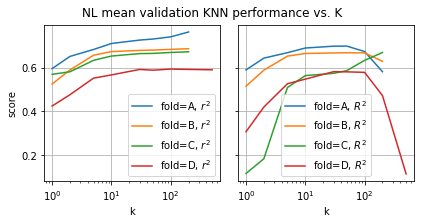

In [27]:
plot_knn_val_performance(nls_mean_result, labels, title='NL mean')

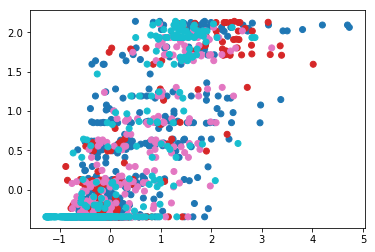

In [31]:
plt.scatter(df['neal_label'], test_preds, c=df['country'].map(COUNTRIES.index), cmap='tab10')